### Requirements
Import the below packages. If an error of "module not found" is shown, use the following commands in your command prompt or Windows Powershell.

- pip install numpy
- pip install pandas
- pip install matplotlib.pyplot
- pip install seaborn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Defining functions to simplify procedure for Multiple Linear Regression (MLR)

The below functions are to define the procedure to compress the Multiple Linear Regression model into a single function and to plot all graphs according to the list of independent and dependent variables. The code are adapted from Data Driven World problem sets with some alterations. Comments are written to give a basic understand of what each function does.

In [2]:
# Define a function such that it is reusable easily
def linear_regression(df_independent, df_dependent, independent_column, dependent_column):
    # Normalize the independents using z normalization
    df_independent = normalize_z(df_independent)

    # Change the independents and the dependent to numpy array using the prepare functions
    X = prepare_independent(df_independent)
    dependent = prepare_dependent(df_dependent)

    iterations = 1500
    alpha = 0.01
    beta = np.zeros((len(independent_column) + 1, 1))
    
    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, dependent, beta, alpha, iterations)

    # call the predict() method
    pred = predict(df_independent, beta)
    
    # Print all of the betas with labels at the side
    for idx in range(len(beta)):
        if idx == 0:
            print("Constant: " + str(beta[idx]))
        else:
            print(independent_column[idx - 1] + ": " + str(beta[idx]))
    print("\n") 

    # change dependent test set to a numpy array
    dependent = prepare_dependent(df_dependent)

    # Calculate r2 score
    r2 = r2_score(dependent, pred)   
    print("r2:", r2)
    
    # Calculate r2_adjusted score
    r2_adj = r2_adjusted(dependent, pred, beta)
    print("r2_adj:", r2_adj)

    # Calculate the RMSE and the mean to compare the data
    rmse = root_mean_squared_error(dependent, pred)

    print("RMSE:", rmse)
    print("Mean:", float(df_dependent.mean()))
    
    print("Relative RMSE:", (rmse / float(df_dependent.mean())))
    
    # Check and verify that the cost function decreases and optimal beta is found
    plt.title(f"Cost function over {iterations} iterations")
    plt.plot(J_storage)
    
    return beta, pred

# Plot all of the relationship with respect to the dependent for visualization
def plot_relationship(df_independent, df_dependent, pred, independent_column, dependent_column):
    for idx in range(len(independent_column)):
        plt.figure(idx)
        plt.scatter(df_independent[independent_column[idx]], df_dependent, label="Actual")
        plt.scatter(df_independent[independent_column[idx]], pred, label="Predicted")
        plt.xlabel(independent_column[idx])
        plt.ylabel(dependent_column[0])
        plt.title(independent_column[idx])
        plt.legend()
        
# Apply Z-normalization on the data to change the data into a standard normal distribution
def normalize_z(df):    
    return (df - df.mean()) / df.std()

# Scale all data from 0 to 1
def normalize_minmax(dfin):
    df_max =  dfin.max(axis = 0)
    df_min = dfin.min(axis = 0)
    dfout = (dfin - df_min) / (df_max - df_min)
    return dfout

# To split the DataFrame into its dependent and independent variables according to the country specified
def get_independents_dependents(df, independent_names, dependent_names):
    df_independent = df.loc[: , independent_names]
    df_dependent = df.loc[: , dependent_names]
    return df_independent, df_dependent

# Add a 1 column on the left of the dataframe for constant and add change the dataframe into a numpy array
def prepare_independent(df_independent):
    left = np.ones((len(df_independent), 1))
    np_independent = df_independent.to_numpy()
    
    # axis = 1 indicates to move it along the x axis or in the way of the columns
    return np.concatenate((left, np_independent), axis=1)

# Change dataframe into a numpy array
def prepare_dependent(df_dependent):
    return df_dependent.to_numpy()

# Calculate and get predicted values
def predict(df_independent, beta):
    df_independent = normalize_z(df_independent)
    df_independent = prepare_independent(df_independent)
    return np.matmul(df_independent, beta)

# Split the input data into training dataset and testing datasets
def split_data(df_independent, df_dependent, random_state=None, test_size=0.5):
    np.random.seed(random_state)

    test_length = int(len(df_independent) * test_size)
    independent = np.random.choice(len(df_independent), len(df_independent), replace=False)
    
    df_independent_test = df_independent.loc[independent[:test_length], :]
    df_independent_train = df_independent.loc[independent[test_length:], :]    
    df_dependent_test = df_dependent.loc[independent[:test_length], :]
    df_dependent_train = df_dependent.loc[independent[test_length:], :]
    
    return df_independent_train, df_independent_test, df_dependent_train, df_dependent_test
  
# Calculate the r2 score to see the fit of the model
def r2_score(y, ypred):
    if type(y) == pd.DataFrame:
        y = y.to_numpy()
        
    if type(ypred) == pd.DataFrame:
        ypred = ypred.to_numpy()
        
    ymean = np.mean(y)
    ss_res = np.sum(np.matmul((y - ypred).T, (y - ypred)))
    ss_tot = np.sum(np.matmul((y - ymean).T, (y - ymean)))
    
    return 1 - (ss_res / ss_tot)
    pass

# r2 adjusted is to take into account the number of variables used in retrospect with the number of data points
def r2_adjusted(dependent, pred, beta):
    r2 = r2_score(dependent, pred)
    n = dependent.shape[0]
    k = beta.shape[0]
    r2_adj = 1 - (((1 - r2) * (n - 1)) / (n - k - 1))
    return r2_adj

# Calculate the mean squared error
def root_mean_squared_error(dependent, pred):
    if type(dependent) == pd.DataFrame:
        dependent = dependent.to_numpy()
        
    if type(pred) == pd.DataFrame:
        pred = pred.to_numpy()
        
    ss_res = np.sum(np.matmul((dependent - pred).T, (dependent - pred)))
    
    mse = 1 / len(dependent) * ss_res
    return math.sqrt(mse)
    pass

# Used to calculate cost function
def compute_cost(X, y, beta):
    inner = np.matmul(X, beta) - y
    J = (1 / (2 * len(X))) * np.matmul(inner.T, inner)
    J = J[0][0]
    return J

# Using gradient descent to optimize the beta found
def gradient_descent(X, y, beta, alpha, num_iters = 1500):
    J_storage = compute_cost(X, y, beta)
    
    for _ in range(num_iters):
        beta = beta - alpha / len(y) * np.matmul(X.T, np.matmul(X, beta) - y)
        J_storage = np.append(J_storage, compute_cost(X, y, beta))
        
    return beta, J_storage

# Introduction

Almost two years have passed since the beginning of the COVID-19 pandemic, and the whole world is still grappling with the disruption that the appearance of the SARS-Cov-2 virus has brought us. This pandemic's effects can be felt very strongly in the exceptional death toll that it has left us with. 

In this study, we will analyze and discuss the impact of several factors affecting the **absolute number of deaths** due to COVID-19. As part of the study, we will build a Multiple Linear Regression (MLR) model that predicts the number of deaths based on some known data of a country.

## Analyzing potential predictor variables

To begin, we start with online research to determine useful predictors that we would like to include in our model. These useful predictors are merely just guides and does not have to be used extensively. 

- **Number of cases**
    - The first intuitive and straightfoward predictor would be the number of cases. As can be seen, with a large amount of cases, can there be a large amount of deaths. Therefore, one of the predictor that we would like is the number of cases.
    
    
- **Health of the people & Age**
    - Based on a study by a group of researchers in Rio de Janerio, it is suggested that an individual's immunity affects the susceptibility to suffer more severe form of infection. It is also found that older people have lower immunity, thus, mortality and lethality increases with age. [[1]](#References)
    
    
- **Skin colour & Gender**
    - Based on the study in Rio de Janerio, skin colour and gender have also been found to be associated with the probability of death. [[1]](#References)
    
    
- **Vaccination Status**
    - Based on a study by the Centers of Disease Control and Prevention (CDC), an individual that has been vaccinated has lower mortality rate. [[2]](#References)
    
    
- **Population, Income, Occupation, & Transport**
    - Based on a study in the United States, it is suggested that the population, income, occupation, and transport has a high association with the spread of the virus. With higher spread of virus, there would be more cases, thus we can also infer that there would be more deaths. [[3]](#References)
    
    
- **Healthcare Systems & Policies**
    - Based on a study in the European Union, a variable found to greatly influence the COVID-19 mortality rate depends on the healthcare system a country has, as well as the policies that they possess. [[4]](#References)

## Finding and reading data set

Through online searches, a comprehensive data set has been found from https://ourworldindata.org/covid-deaths. [[5]](#References)

To begin, we can firstly look at the dataset that we have found and search through the columns and countries that it contains and identify the information that we want. Furthermore, we would also like to verify that the number of countries is more than 20.

In [15]:
# Read the CSV file
owid_csv = pd.read_csv("covid-data.csv")

print("Dataset shape:", owid_csv.shape)
print("Number of locations:", len(pd.unique(owid_csv["location"])), "\n")

print(owid_csv.columns, "\n")

print(owid_csv["location"].unique(), "\n")

Dataset shape: (126246, 65)
Number of locations: 233 

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'ne

## Understanding our data set

### Preliminary cleaning up of data set

Analzying the variables and input of the data above, we can identify outliers such as "World", "Asia", etc, under location. Further analyzing the excel file, it is seen that these information are the sum of all countries in a region and thus we would want to remove them. These data are those without inputs in "continents".

Next, we can also drop data that are non-numerical or not expected to be used in this study such as "iso_code", "continent", and "date". We would like to keep "location" so that we are able to verify that our research contains at least 20 countries as part of our requirements.

Additionally, in this data set, we can see that there are smoothed and non-smoothed datas. Through online research, we would like to use the smoothed data as they are more complete and they have already been modified to remove noise and help us better identify patterns. [[6]](#References)

Lastly, as the goal of this study is to predict the absolute daily number of deaths, we would work with absolute data instead of relative data. Thus we would drop all relative data. However, we would like to keep "hospital_beds_per_thousand" as it is the sole indicator of healthcare system present in this data set.

In [17]:
# Remove data where continent is NAN
owid_df = owid_csv.dropna(subset=["continent"])

# Verify that "World" and "Asia" has been dropped
assert not len(owid_df.loc[owid_df["location"] == "World"])
assert not len(owid_df.loc[owid_df["location"] == "Asia"])

# Removing non-numerical data
owid_df = owid_df.drop(columns=["iso_code", "continent", "date", "tests_units"])

# Removing non smoothed datas
owid_df = owid_df.drop(columns=["new_cases", "new_deaths", "new_tests", "new_vaccinations"])

# Removing relative data
per_columns = [col for col in owid_df if '_per_' in col]
owid_df = owid_df.drop(columns=per_columns)

# Adding back "hospital_beds_per_thousand"
owid_df["hospital_beds_per_thousand"] = owid_csv["hospital_beds_per_thousand"]

# Verify that columns are what we want
owid_df.columns

Index(['location', 'total_cases', 'new_cases_smoothed', 'total_deaths',
       'new_deaths_smoothed', 'reproduction_rate', 'icu_patients',
       'hosp_patients', 'weekly_icu_admissions', 'weekly_hosp_admissions',
       'total_tests', 'new_tests_smoothed', 'positive_rate',
       'total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated',
       'total_boosters', 'new_vaccinations_smoothed', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'extreme_poverty', 'cardiovasc_death_rate',
       'diabetes_prevalence', 'female_smokers', 'male_smokers',
       'handwashing_facilities', 'life_expectancy', 'human_development_index',
       'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative',
       'excess_mortality', 'hospital_beds_per_thousand'],
      dtype='object')

In [5]:
owid_df.to_csv("preliminary-clean.csv")

### Visualizing relationship

To visualize our relationship between the number of deaths and the other variables, we can do a pairplot between our potential dependent variables "new_death_smoothed" and "total_deaths" and the other variables.

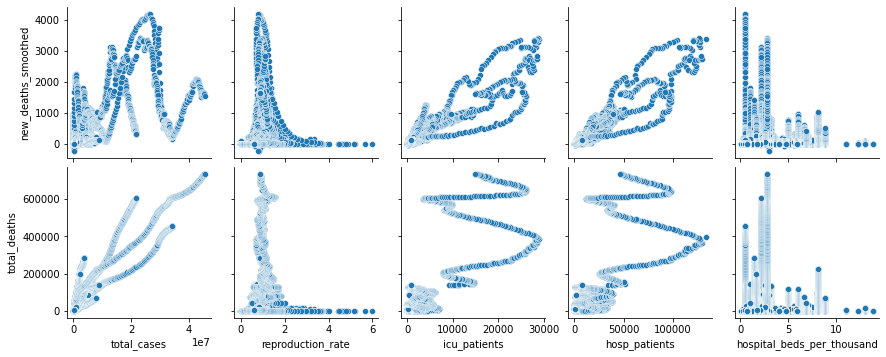

In [10]:
sns.pairplot(owid_df, y_vars=["new_deaths_smoothed", "total_deaths"], x_vars=['total_cases', 'reproduction_rate', 'icu_patients', 'hosp_patients', 'hospital_beds_per_thousand'], dropna=True)

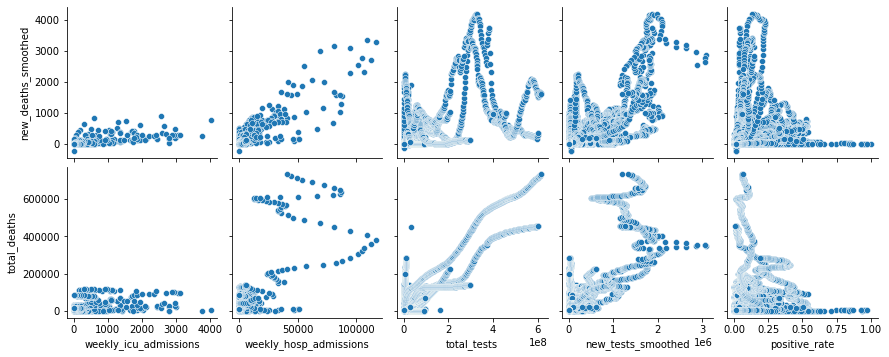

In [7]:
sns.pairplot(owid_df, y_vars=["new_deaths_smoothed", "total_deaths"], x_vars=['weekly_icu_admissions', 'weekly_hosp_admissions', 'total_tests', 'new_tests_smoothed', 'positive_rate'], dropna=True)

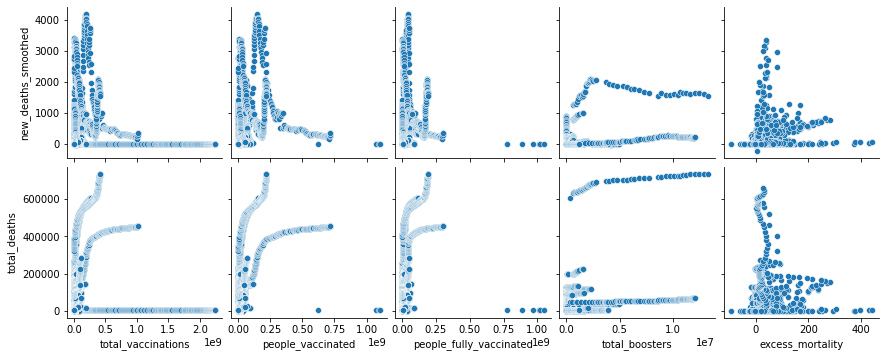

In [28]:
sns.pairplot(owid_df, y_vars=["new_deaths_smoothed", "total_deaths"], x_vars=['total_vaccinations', 'people_vaccinated', 'people_fully_vaccinated','total_boosters', 'excess_mortality'], dropna=True)

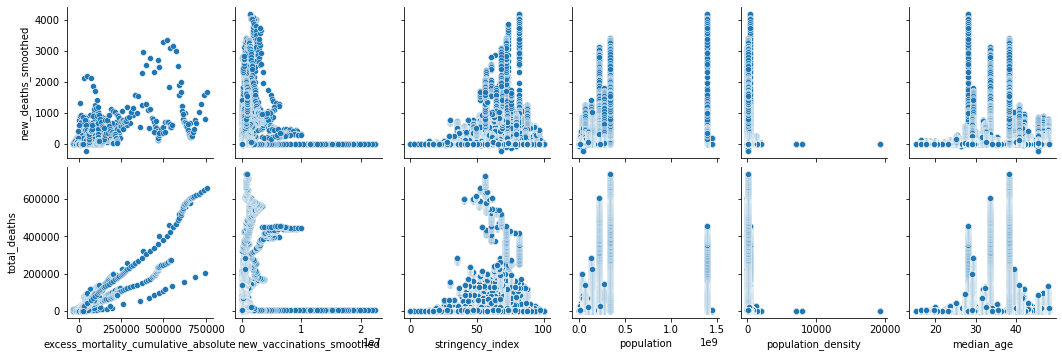

In [29]:
sns.pairplot(owid_df, y_vars=["new_deaths_smoothed", "total_deaths"], x_vars=['excess_mortality_cumulative_absolute', 'new_vaccinations_smoothed', 'stringency_index','population', 'population_density', 'median_age'], dropna=True)

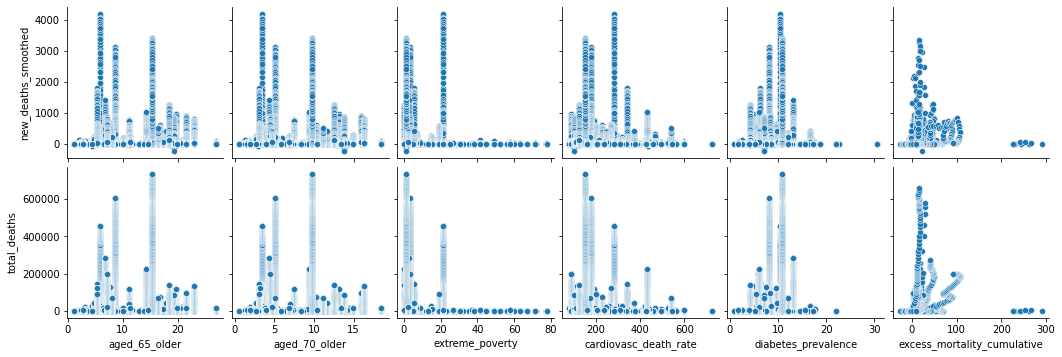

In [30]:
sns.pairplot(owid_df, y_vars=["new_deaths_smoothed", "total_deaths"], x_vars=['aged_65_older','aged_70_older', 'extreme_poverty', 'cardiovasc_death_rate','diabetes_prevalence',  'excess_mortality_cumulative'], dropna=True)

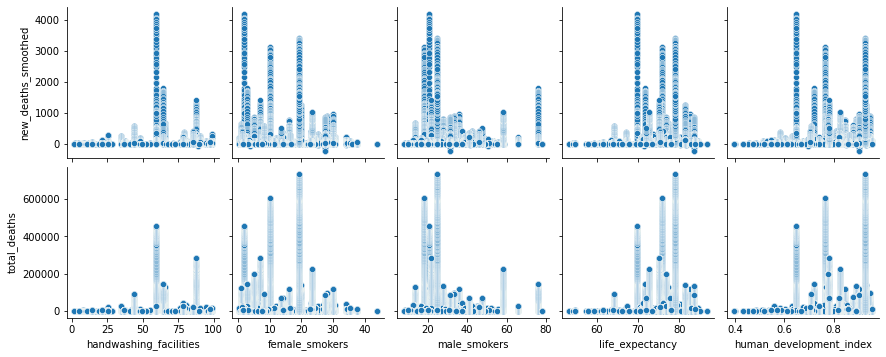

In [31]:
sns.pairplot(owid_df, y_vars=["new_deaths_smoothed", "total_deaths"], x_vars=['handwashing_facilities', 'female_smokers', 'male_smokers', 'life_expectancy', 'human_development_index'], dropna=True)

### Extracting predictor variables & Cleaning up data set

From first glace, our dataset has 2 potential useful dependent variables, "new_deaths_smoothed" and "total_deaths. Looking at the other variables, we can identify that the 2 dependent variables above are paired with "new_cases_smoothed" and "total_cases" respectively. Thus, in our iterations, we would like to use both and compare their accuracy accordingly. In the data set, we are also able to locate some of the potential variables as forementioned.

- **new_deaths_smoothed**
- **total_deaths**
---------------------------------

In the data set, we are also able to locate some of the potential variables as forementioned.
- **new_cases_smoothed / total_cases**
    - This is equivalent to the number of cases and the spread of the virus.
- **people_fully_vaccinated_percent**
    - This is equivalent to the vaccination status. This data is created and modified to show the percentage of vaccinated individuals in the country. Here, we make an assumption that each person in the country has the same probability to be vaccinated. This will be calculated using "people_fully_vaccinated" and "population".
- **life_expectancy**
    - This is used in place as a health status indicator for the country.
- **median_age**
    - This is an indicator of the age of the country.
- **hospital_beds_per_thousand**
    - This is an indicator for the healthcare systems that a country has.
    
----------------------------------------

Lastly, we are going to remove the rows with NAN data so that we are able to ensure that there are no lapses in the data.

In [ ]:
# Create new column called "people_fully_vaccinated_precent"
df = owid_df.copy()
df["people_fully_vaccinated_percent"] = df["people_fully_vaccinated"] / df["population"]

# Listing out the variables that we want to use
columns = ["location", "new_deaths_smoothed", "total_deaths", "new_cases_smoothed", "total_cases",
           "people_fully_vaccinated_percent", "life_expectancy", "median_age", "hospital_beds_per_thousand"] 

# Extract variables 
df = df[columns]

# Remove NAN rows and reset the index
df = df.dropna().reset_index(drop=True)

# Ensure that data is correct
display(df)

------------------------------------

## MLR Iteration 1:

A naive first iteration would be to use all the data points. We can use df_v1 to describe and also understand the data. In our first iteration, we would like to begin with "new_cases_smoothed" and "new_deaths_smoothed" to analyze the relationship between the daily deaths and daily cases.

In [ ]:
df_v1 = df.copy()

# Define independent and dependent columns
independent_column_v1 = ["new_cases_smoothed", "people_fully_vaccinated_percent", "life_expectancy", "median_age", "hospital_beds_per_thousand"] 
dependent_column_v1 = ["new_deaths_smoothed"]

# Describe data
display(df_v1[dependent_column_v1 + independent_column_v1].describe())

# Extract dependent & independent variables
df_independent_v1, df_dependent_v1 = get_independents_dependents(df_v1, independent_column_v1, dependent_column_v1)

# Use the linear_regression function defined above to obtain beta & predicted
beta_v1, pred_v1 = linear_regression(df_independent_v1, df_dependent_v1, independent_column_v1, dependent_column_v1)

### Visualizing data & relationship (Iteration 1)

We can plot each variable and see how the predicted linear data fits accordingly to the actual data. The function to simplify this code can be found in the prelude of this report. [[Functions]](#Defining-functions-to-simplify-procedure-for-Multiple-Linear-Regression-(MLR))

In [ ]:
plot_relationship(df_independent_v1, df_dependent_v1, pred_v1, independent_column_v1, dependent_column_v1)

### Discussion of results from iteration 1

Analyzing the data above, visually, we can see that the actual values and predicted values are considerably similar with a high percentage of predicted values matching the actual values. However, from the plotted diagrams, we can see that there are a lot of data points that are concentrated in certain regions of the graph, indicating that there might be a misbalance in the weightage of each country's contribution.

Numerically, there are still improvements to be made as the r2 adjusted values are only 0.68. Furthermore, we can see that relative RMSE is considerably large. This can be explained as when describing the data, we notice that the standard deviation is significantly large as compared to the mean. 

Another numerical value to note is beta. A strongly correlated variable as predicted is "new_cases_smoothed" which has a significant impact on the model generated. Furthermore, by looking at the other coefficients, we can primarily deduce that the variables supports the hypothesis forementioned. 

From here, we can move on to iteration 2 and try to improve the model.

------------------------------------

## MLR Iteration 2: 
Looking at the first iteration, we can identify a few issues. For example, some countries may have more data points than others. Therefore, countries with more data points will skew the data and cause it to be unbalanced. Thus, we take the mean for each country, and calculate the expected average death per day. 

In [ ]:
df_v2 = df.copy()
unique_countries = df_v2["location"].unique()
df_mean = pd.DataFrame()

# Obtain the mean for each country such that the data is balanced
for country in unique_countries:
    df_country = df_v2.loc[df_v2["location"] == country, :]
    df_country = df_country.mean(numeric_only=True).to_frame().transpose()
    df_country.insert(0, "location", country)
    df_mean = pd.concat([df_mean, df_country], axis = 0)

df_v2 = df_mean.reset_index(drop=True)

# Ensure that number of countries is still more than 20
unique_countries = df_v2["location"].unique()
assert len(df_v2["location"].unique()) >= 20

# Define variables to be analyzed
independent_column_v2 = ["new_cases_smoothed", "people_fully_vaccinated_percent", "life_expectancy", "median_age", "hospital_beds_per_thousand"] 
dependent_column_v2 = ["new_deaths_smoothed"]

# Ensure that data is correct
display(df_v2)
display(df_v2[dependent_column_v2 + independent_column_v2].describe())

# Extract dependent & independent variables
df_independent_v2, df_dependent_v2 = get_independents_dependents(df_v2, independent_column_v2, dependent_column_v2)

# Use the linear_regression function defined above to obtain beta & predicted
beta_v2, pred_v2 = linear_regression(df_independent_v2, df_dependent_v2, independent_column_v2, dependent_column_v2)

### Visualizing data & relationship (Iteration 2)

We can plot each variable and see how the predicted linear data fits accordingly to the actual data. The function to simplify this code can be found in the prelude of this report. [[Functions]](#Defining-functions-to-simplify-procedure-for-Multiple-Linear-Regression-(MLR))

In [ ]:
plot_relationship(df_independent_v2, df_dependent_v2, pred_v2, independent_column_v2, dependent_column_v2)

### Discussion of results from iteration 2

Compared to iteration 1, visually, there are no obvious changes to the relationship and the majority of predicted data still aligns with the actual data. However, we can see that the weights of the data is more evenly spreaded out this time which is supported by the lower standard deviation.

Analyzing it numerically, we can see that the r2 adjusted has increased to 0.81, indicating that it is a better fit in the model with a balanced input weight from each country. Additionally, the relative RMSE has also decreased significantly, indicating that this model gives a better prediction as compared to the previous.

However, a thing to note for beta is that the coefficient for "life_expectancy" has a much less significant impact now. This is unexpected as health has been cited in multiple research to be a big factor in deciding COVID-19 deaths. [[7]](#References) [[8]](#References) One possible explaination for this would be that "life_expectancy" is also an indicator for age, which happens to have a possible correlation with the number of deaths. Furthermore, "life_expectancy" has fluctuated through the pandemic. [[9]](#References) Thus, this indicator might not be good to indicate health.

Another thing to note for beta is that the "hospital_beds_per_thousand" has changed from a negative correlation to a positive one. This is unexpected as better healthcare systems should yield lower deaths. One possible explaination for this would be that a country may increase their hospital beds in order to account for the higher demand in their country. However, as the coefficient is significantly low, we shall use this variable again to verify.

With these considerations in mind, we move onto iteration 3.

------------------------------------

## MLR Iteration 3: 
In the third iteration, we explore the changes when we use tallied data instead of daily data. Another change we would make here would be to exclude "life_expectancy" as it might not be a good indicator for health. Under iteration 3, we would again like to test "hospital_beds_per_thousand" and verify if healthcare systems are a deciding factor in COVID-19 related deaths.

In [ ]:
# We can just use df_v2 again as the procedure is the same
df_v3 = df_v2.copy()

# Define variables to be analyzed
independent_column_v3 = ["total_cases", "people_fully_vaccinated_percent", "hospital_beds_per_thousand", "median_age"] 
dependent_column_v3 = ["total_deaths"]

# Describe new data
display(df_v3[dependent_column_v3 + independent_column_v3].describe())

# Extract dependent & independent variables
df_independent_v3, df_dependent_v3 = get_independents_dependents(df_v3, independent_column_v3, dependent_column_v3)

# Use the linear_regression function defined above to obtain beta & predicted
beta_v3, pred_v3 = linear_regression(df_independent_v3, df_dependent_v3, independent_column_v3, dependent_column_v3)

### Visualizing data & relationship (Iteration 3)

We can plot each variable and see how the predicted linear data fits accordingly to the actual data. The function to simplify this code can be found in the prelude of this report. [[Functions]](#Defining-functions-to-simplify-procedure-for-Multiple-Linear-Regression-(MLR))

In [ ]:
plot_relationship(df_independent_v3, df_dependent_v3, pred_v3, independent_column_v3, dependent_column_v3)

### Discussion of results from iteration 3

Compared to iteration 2, visually, there are no obvious changes to the relationship and the majority of predicted data still aligns with the actual data. However, the spread is still present as there are still some significantly higher number deaths. This is supported by the high standard deviation.

Analyzing it numerically, we can see that the r2 adjusted has increased to 0.87, indicating that there is a better fit in the model with tallied datas computed. Additionally, the relative RMSE has decreased to 1.06, indicating that this model gives a more accurate prediction.

For the coefficients of beta, without "life_expectancy" in consideration, all of the variables support the hypothesis forementioned. 

## Conclusion

In all 3 iterations, we can conclude that the number of COVID-19 related deaths is highly correlated with the number of cases. This is intuitive as a greater spread in virus would mean implication in things such as lower hygiene, more variants, and also a higher amount of people susceptible to COVID-19 deaths.
   
Additionally, we can also conclude that the percentage of people vaccinated in a country and age of the population also affects their mortality. [[1]](#References) [[2]](#References) This is shown in all 3 models as "people_fully_vaccinated_percent" always has a negative correlation and "median_age" always has a positive correlation. Fropm these correlations, we can deduce that higher vaccination count yields more immunity for the people and creates herd immunity. [[10]](#References) We can also deduce that as the "median_age" increases, there would be more elderies who have higher mortality rate, thus, making the overall deaths more. 

However, despite the hypothesis, two fluctuating variables "life_expectancy" and "hospital_beds_per_thousand" has considerably lower coefficients and changes their relationship with the number of deaths. Thus, these 2 variables are inconclusive and requires more testing to verify their relationship.

Through these 3 iterations, we have tested various methods of modelling the number of deaths. Overall, if we take a balanced input from each country and the tallied data, we are able to obtain a better prediction. This can be explained by a surplus of data from wealthier countries, thus skewing the data set. Furthermore, daily cases can fluctate and may not be a good indicator for the number of deaths.

## Comparing Excel and Python Code

Comparing the Excel data and Python code, even though the computed values are slightly different, they are not significantly differently and have the same conclusion. One possible reason could be the iterations or rounding off difference that can happen in the system. 

Overall, the conclusion and discussion on data for both the Excel and Python code applies to both dataset and both information provided are the same. 

------------------------------------

## References

[[1]](#Analyzing-potential-predictor-variables) Cini Oliveira, M., de Araujo Eleuterio, T., de Andrade Corrêa, A.B. et al. Factors associated with death in confirmed cases of COVID-19 in the state of Rio de Janeiro. BMC Infect Dis 21, 687 (2021). https://doi.org/10.1186/s12879-021-06384-1

[[2]](#Analyzing-potential-predictor-variables) Xu S, Huang R, Sy LS, et al. COVID-19 Vaccination and Non–COVID-19 Mortality Risk — Seven Integrated Health Care Organizations, United States, December 14, 2020–July 31, 2021. MMWR Morb Mortal Wkly Rep 2021;70:1520–1524. DOI: http://dx.doi.org/10.15585/mmwr.mm7043e2

[[3]](#Analyzing-potential-predictor-variables) Cifuentes-Faura, J. (2021). Factors influencing the COVID-19 mortality rate in the European Union: importance of medical professionals. Public Health, 200, 1–3. https://doi.org/https://doi.org/10.1016/j.puhe.2021.09.003

[[4]](#Analyzing-potential-predictor-variables) Pasha, D. F., Lundeen, A., Yeasmin, D., &#38; Pasha, M. F. K. (2021). An analysis to identify the important variables for the spread of COVID-19 using numerical techniques and data science. Case Studies in Chemical and Environmental Engineering, 3, 100067. https://doi.org/https://doi.org/10.1016/j.cscee.2020.100067

[[5]](#Finding-and-reading-data-set) Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/coronavirus'

[[6]](#Preliminary-cleaning-up-of-data-set) FDhir, Rajeev. "How Data Smoothing Works". Investopedia, 2021, https://www.investopedia.com/terms/d/data-smoothing.asp.

[[7]](#Discussion-of-results-from-iteration-2) Williamson, E.J., Walker, A.J., Bhaskaran, K. et al. Factors associated with COVID-19-related death using OpenSAFELY. Nature 584, 430–436 (2020). https://doi.org/10.1038/s41586-020-2521-4

[[8]](#Discussion-of-results-from-iteration-2) Upadhyaya, A., Koirala, S., Ressler, R. and Upadhyaya, K. (2020), "Factors affecting COVID-19 mortality: an exploratory study", Journal of Health Research, Vol. ahead-of-print No. ahead-of-print. https://doi.org/10.1108/JHR-09-2020-0448

[[9]](#Discussion-of-results-from-iteration-2) José Manuel Aburto, Jonas Schöley, Ilya Kashnitsky, Luyin Zhang, Charles Rahal, Trifon I Missov, Melinda C Mills, Jennifer B Dowd, Ridhi Kashyap, Quantifying impacts of the COVID-19 pandemic through life-expectancy losses: a population-level study of 29 countries, International Journal of Epidemiology, 2021;, dyab207, https://doi.org/10.1093/ije/dyab207

[[10]](#Conclusion) "Herd Immunity And COVID-19 (Coronavirus): What You Need To Know". Mayo Clinic, 2021, https://www.mayoclinic.org/diseases-conditions/coronavirus/in-depth/herd-immunity-and-coronavirus/art-20486808.